In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import itertools
import pandas as pd
import numpy as np
import nltk
import json
import pickle
import csv

In [2]:
df_final = pd.read_excel('..\dados.xlsx', sheet_name='DS-PN-ID', encoding='utf-8')

In [3]:
dados = df_final

In [4]:
def fit_and_predict(nome, modelo, treino_dados, treino_marcacoes):
    resultado = modelo.fit(treino_dados, treino_marcacoes)
    fit_and_predict_score = str(modelo.score(treino_dados, treino_marcacoes))
    print("ETAPA TREINO "+ nome + "- Acurácia: " + fit_and_predict_score)
    #print("Devio Padrão: " + str(np.std(treino_dados,  dtype=np.float64)))
    print("==============================================================")
    return fit_and_predict_score

def valida_dados(modelo, validacao_dados, validacao_marcacoes):
    resultado = modelo.predict(validacao_dados)
    metricas(resultado,validacao_marcacoes)

def metricas(resultado,validacao_marcacoes):
    
    #Apresentação do report contendo precision, recall and F-measures
    if len(set(resultado)) > 2:
        target_names = ['negativo', 'positivo', 'neutro']
        #os valores acima estão na ordem correta
        print(classification_report(validacao_marcacoes, resultado, target_names=target_names))
    else:
        print("Classification Report\n")
        target_names = ['negativo', 'positivo']
        #os valores acima estão na ordem correta
        print(classification_report(validacao_marcacoes, resultado, target_names=target_names))       

        #Apresentação dos true positive, false positive, true negative e false negative
        tn, fp, fn, tp = confusion_matrix(validacao_marcacoes, resultado).ravel() 
        msg = "True Positive: {0} \nFalse Positive: {1}\nTrue Negative: {2}\nFalse Negative: {3}".format(str(tn),str(fp),str(fn),str(tp))
        print(msg+"\n")

        matrix_confusao(validacao_marcacoes, resultado,target_names)

        print("Metrics\n")
        
        print("Precision: " + str(precision_score(validacao_marcacoes, resultado))) 
        print("Recall: " + str(recall_score(validacao_marcacoes, resultado))) 
        #Cria estatistica dos resultados.
        

    print("F-score: " + str(f1_score(validacao_marcacoes, resultado)))
    taxa_de_acerto_base = max(Counter(validacao_marcacoes).values()) * 100 / len(validacao_marcacoes)
    print("Taxa de acerto base: %f" % taxa_de_acerto_base)

    #Apresentação da accuracy e resultado final
    #print("Acurácia: " + str(accuracy_score(validacao_marcacoes, resultado)))

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Matrix de Confusão Normalizada')
    else:
        print('Matrix de Confusão Não Normalizada')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def matrix_confusao(validacao_marcacoes, resultado, target_names):
    cnf_matrix = confusion_matrix(validacao_marcacoes, resultado)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=target_names,title='Matrix de Confusão, sem normalização')

def cria_modelos(treino_dados, treino_marcacoes):
    resultados = {}
    
    # MultinomialNB
    modeloMultinomial = MultinomialNB(alpha=1.0, fit_prior=True)
    resultadoMultinomial = fit_and_predict("MultinomialNB", modeloMultinomial, treino_dados, treino_marcacoes)
    resultados[resultadoMultinomial] = modeloMultinomial
    
    # AdaBoostClassifier
    modeloAdaBoost = AdaBoostClassifier(random_state=0)
    resultadoAdaBoost = fit_and_predict("AdaBoostClassifier", modeloAdaBoost, treino_dados, treino_marcacoes)
    resultados[resultadoAdaBoost] = modeloAdaBoost
    
    modeloDecisionTree = DecisionTreeClassifier(random_state=0)
    resultadoDecisionTree = fit_and_predict("DecisionTree", modeloDecisionTree, treino_dados, treino_marcacoes)
    resultados[resultadoDecisionTree] = modeloDecisionTree

    modeloRandomForest = RandomForestClassifier(random_state=0)
    resultadoRandomForest = fit_and_predict("RandomForest", modeloRandomForest, treino_dados, treino_marcacoes)
    resultados[resultadoRandomForest] = modeloRandomForest

    modeloLogisticRegression = LogisticRegression(random_state = 0)
    resultadoLogisticRegression = fit_and_predict("LogisticRegression", modeloLogisticRegression, treino_dados, treino_marcacoes)
    resultados[resultadoLogisticRegression] = modeloLogisticRegression

    #Verifica qual modelo teve a melhor perfomance
    maximo = max(resultados)
    return resultados[maximo], resultados

def divide_dados(dados):
    X = dados.Text.values
    y = dados.Sentimento.values 
    return train_test_split(X, y, test_size=0.2, random_state=42)

def pre_processamento(treino_dados, vectorizer):
    return vectorizer.fit_transform(treino_dados)

def pre_processamento_validacao(validacao_dados, vectorizer):
    return vectorizer.transform(validacao_dados)

def processamento_holdout(dados):
    print("\n***************************")
    print("PROCESSAMENTO - HOLDOUT")
    print("***************************")
    treino_dados, validacao_dados, treino_marcacoes, validacao_marcacoes = divide_dados(dados)

    vectorizer = CountVectorizer(analyzer = "word")
    bow_treino = pre_processamento(treino_dados, vectorizer)

    #Encontrando o modelo vencedor
    vencedor,resultados = cria_modelos(bow_treino, treino_marcacoes)
    print("Modelo vencedor: " + str(vencedor)+"\n")

    #Validando o modelo com novos dados
    vencedor.fit(bow_treino, treino_marcacoes)

    bow_validacao = pre_processamento_validacao(validacao_dados, vectorizer)
    valida_dados(vencedor, bow_validacao, validacao_marcacoes) 

    dados = np.concatenate((treino_dados, validacao_dados), axis=0)
    marcacao = np.concatenate((treino_marcacoes, validacao_marcacoes), axis=0)
    return dados, marcacao, resultados


***************************
PROCESSAMENTO - HOLDOUT
***************************
ETAPA TREINO MultinomialNB- Acurácia: 0.9763779527559056
ETAPA TREINO AdaBoostClassifier- Acurácia: 0.8720472440944882
ETAPA TREINO DecisionTree- Acurácia: 1.0
ETAPA TREINO RandomForest- Acurácia: 0.9921259842519685
ETAPA TREINO LogisticRegression- Acurácia: 1.0
Modelo vencedor: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Classification Report

              precision    recall  f1-score   support

    negativo       0.80      0.81      0.80        68
    positivo       0.78      0.77      0.77        60

   micro avg       0.79      0.79      0.79       128
   macro avg       0.79      0.79      0.79       128
weighted avg       0.79      0.79      0.79       128

True Positive: 55 
False Po

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Metrics

Precision: 0.7796610169491526
Recall: 0.7666666666666667
F-score: 0.773109243697479
Taxa de acerto base: 53.125000


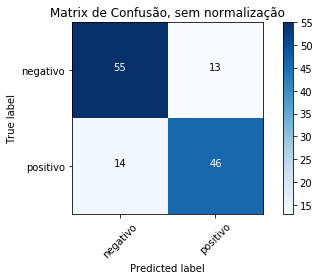

In [5]:
atributos, rotulos, resultados = processamento_holdout(dados)

In [6]:
print("\n***************************\n")
print("PROCESSAMENTO - KFOLD")
print("\n***************************\n")
contador = 1
k = 5


***************************

PROCESSAMENTO - KFOLD

***************************



In [17]:
resultados['0.9763779527559056']

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
atributos

array(['A imprensa é livre? Cadê as pesquisas que mostram Bolsonaro em primeiro? Mas a com Lula que nem candidato pode ser, eles colocam exaustivamente. Claramente Bolsonaro é o candidato a ser batido.',
       '@o_antagonista Estão desesperados. Bolsonaro vão levar no 1o. Turno.',
       'A menina que eu menos gosto na sala vai votar no bolsonaro blz mais um motivo pra ficar longe',
       '@jairbolsonaro Estou contando os dias para ver Bolsonaro na presidência',
       '@jairbolsonaro Tem que fazer no Brasil todo.✌️???? Bolsonaro Presidente.',
       '@roxmo Você continua inútil, enquanto Bolsonaro se tornou o deus dos inúteis...... você já foi melhor, Roger.',
       'Tava na rua com o meu pai e chego um conhecido dele falando q apoia o bolsonaro pq ele vai mata os bandido e sla oq, quase q joguei ele na frente de um caminhão pra dxa de ser retardado',
       '@jairbolsonaro Vamos sr Capitão BOLSONARO governar esse nosso Brasil Continental em 2019? Se Deus quiser, nós vamos chegar l